## Sequence-to-Sequence LSTM: Predicting the Second Sentence (Random Embeddings)

The LSTM model implemented in this repo draws from the [Sequence to Sequence Learning with Neural Networks (2014)](https://arxiv.org/pdf/1409.3215) paper from 2014 written by Google researchers Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. The original paper uses an encoder/decoder LSTM model to convert English to French. Ben Trevett, an NLP engineer, implemented a similar but simplified seq-2-seq model based on the Google paper. There are many code segments that I'm using from Ben's implementation that can be found in his GitHub repo [here](https://github.com/bentrevett/pytorch-seq2seq).

The main difference between my code and Ben's code is that I'll be implementing a version of `nn.LSTM` myself, rather than using pytorch's pre-built implementation. Some additional differences in my implementation:

- Source vocabulary and target vocabulary are identical (as nothing is being translated)
- Doing all dataset creation/preprocessing myself
- Running everything on CPU vs. GPU

I also found a handful of other articles/videos really useful:

- [PyTorch LSTM documentation]("https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html"): This was useful in understanding what my LSTMCell class needed to have in order to function with my Encoder, Decoder, and S2S classes as well as working with PyTorch's autodifferentiation, SGD, and cross entropy loss functions.

- [StatQuest YouTube Channel]("https://www.youtube.com/watch?v=L8HKweZIOmg&t=24s&ab_channel=StatQuestwithJoshStarmer"): StatQuest YouTube channel has a bunch of videos on sequence to sequence problems, which helped with the intuitive understanding. He also has videos that implement seq-2-seq using PyTorch Lightning. He follow's Ben's repository as well.

- [Mustafa Murat ARAT Blog]("https://mmuratarat.github.io/2019-01-19/dimensions-of-lstm"): This article was helpful in understanding the dimensionality of weights/biases


#### Imports:

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim
import tqdm
import evaluate

EMBED_SIZE = 200

/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/will/miniconda3/envs/pycourse/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Set all random seeds (for testing purposes, will remove):

In [2]:
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)

#### Pre-process the Training Data

training_firsts (and seconds) will be a lists of length 6036 each. Each element of these lists is a sentence vector, where each element corresponds to the words in the sentence. both `<s>` and `</s>` are included in each sentence vector. 

In [3]:
# TRAINING
training_size = 6036
training_firsts = []
training_secs = []
with open("bobsue-data/bobsue.seq2seq.train.tsv") as trainfile:
    for line in trainfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        training_firsts.append(sent1)
        training_secs.append(sent2)


Now, we repeat for validation and testing sets:

In [4]:
# VALIDATION
validation_size = 750
valid_firsts = []
valid_secs = []
with open("bobsue-data/bobsue.seq2seq.dev.tsv") as valfile:
    for line in valfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        valid_firsts.append(sent1)
        valid_secs.append(sent2)

# TESTING
testing_size = 750
test_firsts = []
test_secs = []
with open("bobsue-data/bobsue.seq2seq.test.tsv") as testfile:
    for line in testfile:
        separated = line.split()
        for i in range(len(separated)):
            if separated[i] == "</s>":
                sent1 = separated[:i + 1]
                sent2 = separated[i + 1:]
                break
        test_firsts.append(sent1)
        test_secs.append(sent2)


#### Generating Embeddings: Random Initialization

Instead of using GloVe's pre-trained embeddings, we'll be randomly initializing our embeddings of dimension `EMBED_SIZE`:

First, we'll generate our target vocabulary from our `bobsue.voc.txt` file

In [5]:
#Pre-process target vocabulary
target_voc = []
with open('bobsue-data/bobsue.voc.txt') as vocfile:
    for line in vocfile:
        line = line.split()
        target_voc.append(line[0])
target_voc = np.array(target_voc)

Now, we assign a normally distributed random vector of dimension EMBED_SIZE. `target_voc` is a `numpy` array where each element is a word that appears in our training/testing data.

In [6]:
tgt_vocab_len = len(target_voc)
target_embeddings = {}
word_to_index = {}
for i in range(tgt_vocab_len):
    cur_word = target_voc[i]
    target_embeddings[cur_word] = np.random.normal(scale=0.6, size=(EMBED_SIZE, ))
    word_to_index[cur_word] = i

Create a dictionary `target_to_index` from a target word to its corresponding index (does the inverse of calling `target_voc[i]`). Then, we'll define `tokenized_to_indices` to convert a tokenized sentence into a list of integers corresponding to the index in our vocabulary.

In [7]:
target_to_index = {}
index_to_target = {}
index_to_embedding = []
for i, word in enumerate(target_voc):
    target_to_index[word] = i
    index_to_target[i] = word

for i in range(len(target_voc)):
    target = index_to_target[i]
    embedding = target_embeddings[target]
    index_to_embedding.append(embedding)

index_to_embedding = np.array(index_to_embedding)
index_to_embedding = torch.from_numpy(index_to_embedding).float()


In [8]:
def tokenized_to_indices(tokens):
    indices = []
    for i in range(len(tokens)):
        indices.append(target_to_index[tokens[i]])
    return indices

We need to convert all of our training sentences into tensors of numerical embeddings. First we'll write a function that takes a tokenized sentence and outputs the corresponding tensor.

In [9]:
def sent_to_embed(tokenized_seq):
    """
    Given a tokenized sentence (where tokenized seq is a vector of tokens for a given sentence),
    returns the a vector where each element corresponds to the embedding of that word
    """
    embeddings = []
    for token in tokenized_seq:
        cur_embedding = target_embeddings[token]
        embeddings.append(cur_embedding)
    embeddings = np.array(embeddings)
    embeddings = torch.from_numpy(embeddings).float()
    return embeddings


### Aggregating our data:
Now, we'll create full datasets for training, validation, and testing.

In [10]:
#Training Data
training_data = []
for i in range(len(training_firsts)):
    cur_pair_data = {
        'src_tokens' : training_firsts[i],
        'tgt_tokens' : training_secs[i],

        'src_len' : len(training_firsts[i]),
        'tgt_len' : len(training_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(training_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(training_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(training_firsts[i]),
        'tgt_embeddings' : sent_to_embed(training_secs[i])
        }
    training_data.append(cur_pair_data)

We'll repeat the process for validation and testing:

In [11]:
#VALIDATION DATA
validation_data = []
for i in range(len(valid_firsts)):
    cur_pair_data = {
        'src_tokens' : valid_firsts[i],
        'tgt_tokens' : valid_secs[i],

        'src_len' : len(valid_firsts[i]),
        'tgt_len' : len(valid_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(valid_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(valid_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(valid_firsts[i]),
        'tgt_embeddings' : sent_to_embed(valid_secs[i])
        }
    validation_data.append(cur_pair_data)

In [12]:
#TESTING DATA
testing_data = []
for i in range(len(test_firsts)):
    cur_pair_data = {
        'src_tokens' : test_firsts[i],
        'tgt_tokens' : test_secs[i],

        'src_len' : len(test_firsts[i]),
        'tgt_len' : len(test_secs[i]),

        'src_indices' : torch.tensor(tokenized_to_indices(test_firsts[i]), dtype=torch.int16),
        'tgt_indices' : torch.tensor(tokenized_to_indices(test_secs[i]), dtype=torch.int16),

        'src_embeddings' : sent_to_embed(test_firsts[i]),
        'tgt_embeddings' : sent_to_embed(test_secs[i])
        }
    testing_data.append(cur_pair_data)

### Building the Model
We've now prepared our training, validation, and testing data. We now need to build the LSTM model, Encoder, and Decoder.

In [13]:
from model import Encoder, Decoder, S2S

#See model.py for encoder, decoder, and seq-2-seq classes

encoder = Encoder(EMBED_SIZE, EMBED_SIZE)
decoder = Decoder(EMBED_SIZE, EMBED_SIZE, index_to_embedding)
s2s = S2S(encoder, decoder)

Initalize weights: the paper uses uniform between -0.08 and 0.08. Set up optimizer and loss functions: I'm using SGD and cross entropy loss.

In [14]:
def init_weights(model):
    for name, parameter in model.named_parameters():
        nn.init.uniform_(parameter.data, -0.08, 0.08)

### Training the Model

Training Loop:

In [15]:
def train_fn(model, optimizer, criterion, training_data):
    model.train()
    epoch_loss = 0
    for i in range(len(training_data)):
        src = training_data[i]['src_embeddings']
        tgt = training_data[i]['tgt_embeddings']
        
        optimizer.zero_grad()
        output = model(src, tgt, tf=True)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss/len(training_data)

Evaluation Loop: (no updating parameters)

In [16]:
def eval_fn(model, criterion, val_data):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i in range(len(val_data)):
            src = val_data[i]['src_embeddings']
            tgt = val_data[i]['tgt_embeddings']

            output = model(src, tgt, tf=False)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss/len(val_data)

Model Training:

In [17]:
s2s.apply(init_weights)
optimizer = optim.Adam(s2s.parameters())
criterion = nn.MSELoss()

n_epochs = 20
best_valid_loss = float("inf")

#Testing with subsets
#subset_size = 1000
#train_subs = training_data[:subset_size]
#valid_subs = validation_data[:subset_size]

training_losses = []
valid_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(s2s, optimizer, criterion, training_data)
    valid_loss = eval_fn(s2s, criterion, validation_data)

    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\tTrain Loss: {train_loss}")
    print(f"\tValid Loss: {valid_loss}")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(s2s.state_dict(), "saved_lstm_random.pt")   

  5%|▌         | 1/20 [01:39<31:25, 99.25s/it]

	Train Loss: 0.1604881596049779
	Valid Loss: 0.1365623522202174


 10%|█         | 2/20 [03:17<29:39, 98.84s/it]

	Train Loss: 0.13425994638262242
	Valid Loss: 0.13128603783249854


 15%|█▌        | 3/20 [04:55<27:48, 98.17s/it]

	Train Loss: 0.13181882631218814
	Valid Loss: 0.1304483191470305


 20%|██        | 4/20 [06:32<26:03, 97.69s/it]

	Train Loss: 0.1312354102143197
	Valid Loss: 0.13023689003785452


 25%|██▌       | 5/20 [08:09<24:23, 97.55s/it]

	Train Loss: 0.13094905447005
	Valid Loss: 0.12999366686741512


 30%|███       | 6/20 [09:46<22:42, 97.33s/it]

	Train Loss: 0.13074777208668575
	Valid Loss: 0.12983183401823045


 35%|███▌      | 7/20 [11:23<21:05, 97.34s/it]

	Train Loss: 0.13062245113993615
	Valid Loss: 0.12967652224500975


 40%|████      | 8/20 [13:00<19:26, 97.24s/it]

	Train Loss: 0.13050448713420518
	Valid Loss: 0.12955948971708617


 45%|████▌     | 9/20 [14:37<17:46, 96.98s/it]

	Train Loss: 0.13041417803948607
	Valid Loss: 0.12954327907164892


 50%|█████     | 10/20 [16:13<16:09, 96.91s/it]

	Train Loss: 0.1303487495748194
	Valid Loss: 0.12944649589061738


 55%|█████▌    | 11/20 [17:50<14:32, 96.94s/it]

	Train Loss: 0.13029122262738888
	Valid Loss: 0.1293997336626053


 60%|██████    | 12/20 [19:28<12:57, 97.14s/it]

	Train Loss: 0.1302394940881361
	Valid Loss: 0.1294043474892775


 65%|██████▌   | 13/20 [21:05<11:20, 97.25s/it]

	Train Loss: 0.13021022158522452
	Valid Loss: 0.12947962377468744


 70%|███████   | 14/20 [22:43<09:43, 97.19s/it]

	Train Loss: 0.13018055474959594
	Valid Loss: 0.12949273021022478


 75%|███████▌  | 15/20 [24:18<08:02, 96.53s/it]

	Train Loss: 0.13014616276587454
	Valid Loss: 0.1294975049197674


 80%|████████  | 16/20 [25:51<06:22, 95.66s/it]

	Train Loss: 0.13011418533807087
	Valid Loss: 0.12927401452263196


 85%|████████▌ | 17/20 [27:24<04:44, 94.85s/it]

	Train Loss: 0.13008359488719462
	Valid Loss: 0.12932250154018402


 90%|█████████ | 18/20 [28:56<03:08, 94.07s/it]

	Train Loss: 0.13006822946694332
	Valid Loss: 0.12934322230021159


 95%|█████████▌| 19/20 [30:30<01:34, 94.03s/it]

	Train Loss: 0.13004241316814427
	Valid Loss: 0.12945770542820295


100%|██████████| 20/20 [32:03<00:00, 96.18s/it]

	Train Loss: 0.13001612693224426
	Valid Loss: 0.12924343450864156


In [18]:
def convert_to_english(embeddings, index_to_embedding, index_to_target):
    tokens = []
    for i in range(len(embeddings)):
        minimum = np.Inf
        minimum_index = -1
        for j in range(len(index_to_embedding)):
            if torch.norm(index_to_embedding[j] - embeddings[i]) < minimum:
                minimum = torch.norm(index_to_embedding[j] - embeddings[i])
                minimum_index = j
        tokens.append(index_to_target[minimum_index])
    
    return tokens

In [19]:
def test(model, test_data, index_to_embedding, index_to_target):
    model.eval()
    epoch_loss = 0
    predicted_tokens = []
    actual_tokens = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(test_data))): #TODO::: CHANGE MEEEE
            src = test_data[i]['src_embeddings']
            tgt = test_data[i]['tgt_embeddings']

            output = model(src, tgt, tf=False)
            predicted_tokens.append(convert_to_english(output, index_to_embedding, index_to_target))
            actual_tokens.append(convert_to_english(test_data[i]['tgt_embeddings'], index_to_embedding, index_to_target))

            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss/len(test_data), predicted_tokens, actual_tokens

test_loss, predictions_tokens, actuals_tokens = test(s2s, testing_data, index_to_embedding, index_to_target)

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [02:22<00:00,  5.27it/s]


Plotting Train/Validation error as a function of epoch:

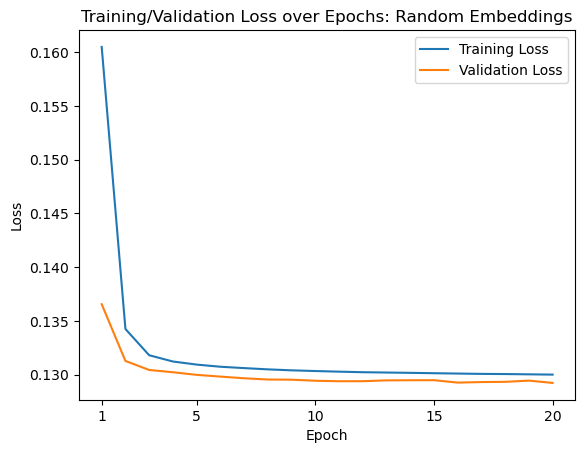

In [20]:
import matplotlib.pyplot as plt
epochs_x = np.arange(n_epochs, dtype=int) + 1
xticks = [1]
for i in range(2, n_epochs + 1):
    if i % 5 == 0:
        xticks.append(i)

fig, ax = plt.subplots()
ax.plot(epochs_x, training_losses, label="Training Loss")
ax.plot(epochs_x, valid_losses, label="Validation Loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.set_title("Training/Validation Loss over Epochs: Random Embeddings")
ax.set_xticks(xticks)
ax.legend()


In [29]:
incorrect_indices = []
for i in range(len(actuals_tokens)):
    if actuals_tokens[i] != predictions_tokens[i]:
        
        incorrect_indices.append(i)

len(incorrect_indices)


0

For some reason, my model is showing no incorrect indices --> all predictions are correct. This can't be true because we have loss (that's even greater than using the GloVe prediction), but I'm not exactly sure how to resolve this.